In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 
import ktrain
from ktrain import vision as vis
from ktrain import text as txt

Using TensorFlow backend.


# Additional Features

In this notebook, we will demonstrated some additional features of *ktrain*.  To demonstrate these features, we will first load some sample data and define a simple model that trains fast. As usual, we will wrap the model and data in a *ktrain* Learner object.

In [2]:
# load  and prepare data as you normally would in Keras
from keras.preprocessing import sequence
from keras.datasets import imdb
NUM_WORDS = 20000
MAXLEN = 400
def load_data():
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)
    x_train = sequence.pad_sequences(x_train, maxlen=MAXLEN)
    x_test = sequence.pad_sequences(x_test, maxlen=MAXLEN)
    return (x_train, y_train), (x_test, y_test)
(x_train, y_train), (x_test, y_test) = load_data()

In [3]:
# build a model as you normally would in Keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D
def get_model():
    model = Sequential()
    model.add(Embedding(NUM_WORDS, 50, input_length=MAXLEN))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = get_model()

In [4]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data = (x_test, y_test))

## Debugging Keras Models

When debugging neural networks, it is sometimes useful to [inspect the results of intermediate layers](https://stackoverflow.com/questions/42233963/debugging-keras-intermediate-layer-or-objective-variables-with-tensorflow). *ktrain* makes this easy with the ```print_layers``` and  ```layer_output``` methods.  The ```print_layers``` method prints the layers of your network with each layer being assigned an index.  The output of ```print_layers``` also shows which layers are trainable (unfrozen) and untrainable (frozen).

In [5]:
learner.print_layers()

0 (trainable=True) : <keras.layers.embeddings.Embedding object at 0x7fef21ba1630>
1 (trainable=True) : <keras.layers.pooling.GlobalAveragePooling1D object at 0x7fef615d2978>
2 (trainable=True) : <keras.layers.core.Dense object at 0x7fef21ba1a20>


The ```layer_output``` method accepts a layer ID as input.  By default, it will print the output of the layer associated with the layer ID using the first example in the training set.  The example_id and use_val arguments can control which example is used to generate the output.  In the example below, we print the output of the Dense layer of our network using the sixth example from our validation set (i.e., the example with index 5 in the x_test array).  

In [6]:
learner.layer_output(2, example_id=5, use_val=True)

array([[0.5021722]], dtype=float32)

Since the model has not yet been trained, it returns 0.5.

Here, we print the output of the  GlobalAveragePooling1D layer (layer_id=1) implicitly using the first example from our training set.

In [7]:
learner.layer_output(1)

array([[ 0.01985349,  0.01797616,  0.00768716,  0.01086807, -0.00389386,
         0.02317831,  0.01343222, -0.01643868, -0.01331068,  0.02354778,
         0.01323409, -0.01311248,  0.0146046 , -0.00389829,  0.01636399,
         0.00730253,  0.00467584, -0.00357863,  0.00089679,  0.00469155,
        -0.0008286 , -0.01487454,  0.00945726,  0.01476656, -0.01599534,
        -0.00897129,  0.01405153, -0.01615895,  0.01372997,  0.01332673,
         0.01045256,  0.00671018, -0.0214887 , -0.01945291,  0.01838193,
        -0.01295422, -0.00955275, -0.0162131 ,  0.00412493, -0.01946823,
         0.01611677, -0.00707382, -0.02242885,  0.02206227, -0.00108859,
        -0.00486699, -0.02041266,  0.00096747, -0.00788511, -0.00195589]],
      dtype=float32)

## Saving the Current Model

When issuing calls to ```autofit```, ```fit_onecycle```, and ```fit```, it is sometimes useful to periodically save the model in case additional training results in overfitting.  This can be accomplished with the ```learner.save_model``` and ```learner.load_model``` methods, which are simply wrappers to ```model.save``` and ```load_model``` in Keras. Example usage is shown below:

In [9]:
learner.save_model('/tmp/mymodel')
# train further here
# if overfitting, then do this:
learner.load_model('/tmp/mymodel')

## Built-In Callbacks

*ktrain* enables easy access to [EarlyStopping](https://keras.io/callbacks/#earlystopping), [ModelCheckpoint](https://keras.io/callbacks/#modelcheckpoint), and [ReduceLROnPlateau](https://keras.io/callbacks/#reducelronplateau) callbacks. All of the **fit** methods of *ktrain* have both an ```early_stopping``` argument and a ```checkpoint_folder``` argument.  When setting ```early_stopping=3```, for instance, the training will disconinue automatically when the validation loss fails to improve after a 3 epochs.  When suppying the path to a folder using ```checkpoint_folder``` argument, files containing the weights obtained after each epoch will be saved to the folder.  In the example below, we will train our model using the ```fit``` method using both arguments.

In [8]:
learner.fit(0.005, 10, cycle_len=1, cycle_mult=2, early_stopping=3, checkpoint_folder='/tmp')

Train on 25000 samples, validate on 25000 samples
Epoch 1/1023
25000/25000 [==============================] - 6s 226us/step - loss: 0.4247 - acc: 0.8212 - val_loss: 0.3434 - val_acc: 0.8716
Epoch 2/1023
25000/25000 [==============================] - 5s 219us/step - loss: 0.2603 - acc: 0.9010 - val_loss: 0.2838 - val_acc: 0.8870
Epoch 3/1023
25000/25000 [==============================] - 5s 211us/step - loss: 0.1755 - acc: 0.9414 - val_loss: 0.2758 - val_acc: 0.8910
Epoch 4/1023
25000/25000 [==============================] - 5s 220us/step - loss: 0.1726 - acc: 0.9360 - val_loss: 0.3020 - val_acc: 0.8806
Epoch 5/1023
25000/25000 [==============================] - 6s 222us/step - loss: 0.1176 - acc: 0.9620 - val_loss: 0.3150 - val_acc: 0.8834
Epoch 6/1023
25000/25000 [==============================] - 1s 41us/step


Early stopping due to no further improvement.
final loss:0.27580805318832396, final score:0.89096


The weights obtained after each of the six epochs will be available as files stored in the checkpoint_folder:

```
/tmp/weights-01.hdf5  /tmp/weights-03.hdf5  /tmp/weights-05.hdf5  
/tmp/weights-02.hdf5  /tmp/weights-04.hdf5  /tmp/weights-06.hdf5
```

These weights can be easily loaded into the model as one would normally do:
```
learner.model.load_weights('/tmp/weights-02.hdfs')
```

The ```checkpoint_folder``` argument can be used with any "fit" method (i.e., ```autofit```, ```fit_onecycle```, and ```fit```).  It is particularly useful when needing to rollback to an earlier epoch in case the model overfits.

In addition, the ```autofit``` method includes a **reduce_on_plateau** parameter, which can be used to automatically reduce the maximum (and base) learning rates in the [triangular learning rate policy](https://arxiv.org/abs/1506.01186) when the validation loss no longer improves by a factor specified by the **reduce_factor** argument.  The criterion can be changed to validation accuracy using the **monitor** argument. When ```autofit``` is called without an **epochs** parameter, both the **early_stopping** and **reduce_on_plateau** are automatically enabled.

## Custom Callbacks

The ```fit```, ```autofit```, and ```fit_onecycle``` methods of the Learner object can also accept custom callbacks, just as you can in standard calls to ```model.fit```.  For instance, here we re-train our model and print the ROC-AUC score after each epoch:

In [5]:
# define a custom callback for ROC-AUC
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
RocAuc = RocAucEvaluation(validation_data=(x_test, y_test), interval=1)



In [6]:
# re-create our model from scratch and train using our custom ROC-AUC callback
learner = ktrain.get_learner(get_model(), train_data=(x_train, y_train), val_data = (x_test, y_test))
learner.autofit(0.005, 2, callbacks=[RocAuc])



begin training using triangular learning rate policy with max lr of 0.005...
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 6s 233us/step - loss: 0.4731 - acc: 0.7872 - val_loss: 0.3279 - val_acc: 0.8738

 ROC-AUC - epoch: 1 - score: 0.942057 

Epoch 2/2
25000/25000 [==============================] - 6s 223us/step - loss: 0.2555 - acc: 0.9056 - val_loss: 0.2834 - val_acc: 0.8886

 ROC-AUC - epoch: 2 - score: 0.952614 



## Inspecting Misclassifications

Once a model is trained, it can be useful to inspect misclassifications, as this may help shed light on how a model architecture or the data-processing pipeline can be improved. 

### Inspecting Image Classification

Let's train a classifier to distinguish cat pictures from dog pictures, as we did in a previous tutorial, which can be downloaded from [here](https://www.kaggle.com/c/dogs-vs-cats/data).

In [16]:
DATADIR = 'data/dogscats'
(train_data, val_data, preproc) = vis.images_from_folder(
                                              datadir=DATADIR,
                                              data_aug = vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'valid'], 
                                              target_size=(224,224), color_mode='rgb')
model = vis.image_classifier('pretrained_resnet50', train_data, val_data, freeze_layers=80)
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data, 
                             workers=8, use_multiprocessing=False, batch_size=64)

Found 23000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
pretrained_resnet50 model created.


In [17]:
learner.autofit(1e-4, 1)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/1
359/359 [==============================] - 84s 234ms/step - loss: 0.2707 - acc: 0.9251 - val_loss: 0.0445 - val_acc: 0.9865


The ```view_top_losses``` method can be used to display the most misclassified examples in the validation set.  This can sometimes provide insights into how to improve a model or data-processing.

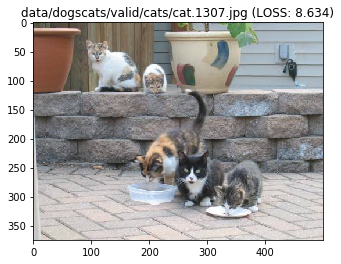

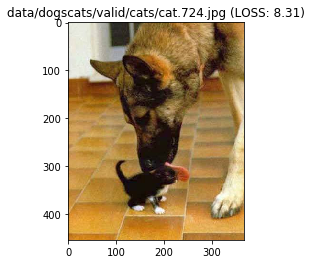

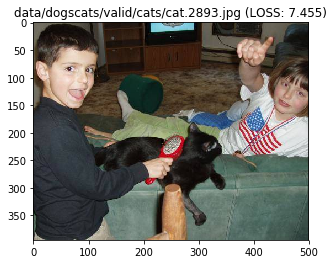

In [22]:
learner.view_top_losses(preproc, n=3)

The top 3 misclassified examples are each challenging in different ways.  For instance, the second image contains both a dog and a kitten but is only labeled as cat because this dataset treats classes as mutually exclusive.

### Inspecting Text Classifications

Let's re-load the IMDb data set of positive and negative movie reviews from a folder and train a simple logistic regression model to perform sentiment analysis, as we did in a previous tutorial.

The dataset can be downloaded from [here](http://ai.stanford.edu/~amaas/data/sentiment/). 

In [4]:
DATADIR = 'data/aclImdb'
(x_train, y_train), (x_test, y_test), preproc = txt.texts_from_folder(DATADIR, 
                                                                         max_features=80000, maxlen=2000, 
                                                                         ngram_range=1, 
                                                                         classes=['pos', 'neg'])
model = txt.text_classifier('logreg', (x_train, y_train))
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test))

Word Counts: 88582
Nrows: 25000
25000 train sequences
Average train sequence length: 237
25000 test sequences
Average test sequence length: 229
Pad sequences (samples x time)
x_train shape: (25000,2000)
x_test shape: (25000,2000)
y_train shape: (25000,2)
y_test shape: (25000,2)
Is Multi-Label? False
compiling word ID features...
max_features is 80000
done.


In [5]:
learner.autofit(0.001, 3)



begin training using triangular learning rate policy with max lr of 0.001...
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 6s 223us/step - loss: 0.4237 - acc: 0.8433 - val_loss: 0.3365 - val_acc: 0.8826
Epoch 2/3
25000/25000 [==============================] - 5s 210us/step - loss: 0.2496 - acc: 0.9236 - val_loss: 0.2997 - val_acc: 0.8886
Epoch 3/3
25000/25000 [==============================] - 5s 205us/step - loss: 0.1927 - acc: 0.9453 - val_loss: 0.2889 - val_acc: 0.8901


In [6]:
learner.view_top_losses(preproc, n=3)

----------
val_id:19432 (LOSS: 9.513)

comanche moon had everything going for it for starters simon back a man who's name is synonymous with high quality tv westerns unfortunately the problems with moon are something even the most talented director couldn't solve a poor script based on a lackluster novel br br forget historical accuracies as any reader of the novels can tell you the biggest travesty in moon is that it's not even consistent with information from the original lonesome dove masterpiece so many wonderful rich moments in the miniseries and to an even greater degree the book are completely missing in moon considering the fact that most viewers of moon are probably coming with at least some sort of dove background the lack of character driven and emotional backstory is downright painful br br that said moon is one instance where the adapted version could and should have been altered to make it more suitable for the screen for example the novel moon focuses largely on the them

The reviews are automatically converted back from post-processed versions of documents with word IDs.  As a result, the punctuation is missing.  Nevertheless, in reading these reviews, it is easy to see why they are challenging.  For instance, the review of Comanche Moon (ID: 19432 in validation set), is negative but makes a lot of positive commentary about the Lonsome Dove miniseries, which is not the subject of the review.  The Comanche Moon miniseries is a prequel to the popular Lonsome Dove miniseries.

## Previewing Data Augmentation

*ktrain* allows you to preview a data augmentation prior to use in training. We will re-use the Dogs vs. Cats dataset from above. Let's set the location of the data and instantiate a data augmentation scheme using the ```ktrain.vision.get_data_aug``` function.

In [2]:
DATADIR = 'data/dogscats'
data_aug = vis.get_data_aug(horizontal_flip=True)

Let's examine the data augmentaiton parameters, which will be the parameters enabled by default plus horizontal_flip=True. Note that the data_aug object is simply a Keras **ImageDataGenerator** object.

In [3]:
data_aug.__dict__

{'featurewise_center': True,
 'samplewise_center': False,
 'featurewise_std_normalization': True,
 'samplewise_std_normalization': False,
 'zca_whitening': False,
 'zca_epsilon': 1e-06,
 'rotation_range': 40,
 'width_shift_range': 0.2,
 'height_shift_range': 0.2,
 'shear_range': 0.0,
 'zoom_range': [0.8, 1.2],
 'channel_shift_range': 0.0,
 'fill_mode': 'nearest',
 'cval': 0.0,
 'horizontal_flip': True,
 'vertical_flip': False,
 'rescale': None,
 'preprocessing_function': None,
 'dtype': 'float32',
 'interpolation_order': 1,
 'data_format': 'channels_last',
 'channel_axis': 3,
 'row_axis': 1,
 'col_axis': 2,
 '_validation_split': 0.0,
 'mean': None,
 'std': None,
 'principal_components': None,
 'brightness_range': None}

Finally, let's run the data augmentation scheme for four images on a selected cat photo:

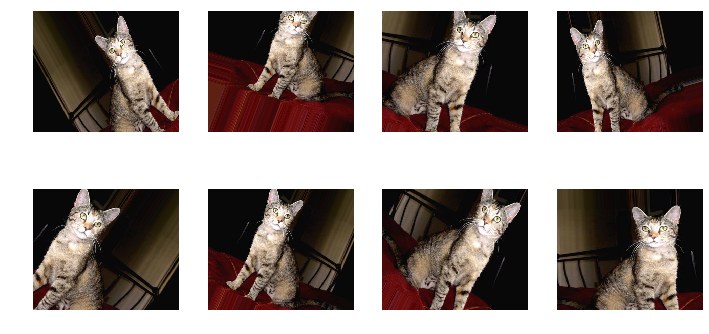

In [8]:
vis.preview_data_aug(DATADIR+'/train/cats/cat.10000.jpg', data_aug, n=8, rows=2)